In [15]:
import pandas as pd
import epipi
import matplotlib.pyplot as plt
import arviz as az
import numpy as np
# import rpy2.robjects as robjects
import branchpro
import scipy.stats
from branchpro.apps import ReproductionNumberPlot

In [72]:
# Data Preparation
omega = pd.read_csv('./PCR_curve_summary.csv')['median'].values
omega_pos_list = np.arange(1, 31) * 10
omega = omega[omega_pos_list]
theta = pd.read_csv('../EpiOS/y_interpolated.csv')['y_interpolated'].values
theta_true = pd.read_csv('../EpiOS/true_infection.csv')['True'].values
# theta = theta - 0.5 * theta[0]
incidences_true = pd.read_csv('../EpiOS/incidences_true.csv')['incidences_true'].values

## Use PyStan with kernel at the end of time sample

In [ ]:
prior = []
for i in range(len(theta)):
    prior.append(epipi.NormalPrior(1000, 200))
prior.append(epipi.NormalPrior(0, 1))

In [73]:
# theta = theta_true
kernel = [0, 0, 0]
starting_time_point = 0
end_time_point = len(theta)
controller = epipi.InferenceController(theta[starting_time_point:end_time_point], omega, kernel=kernel)
fit, samples = controller.run()
df = az.summary(samples)
df

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 28: Argument
    1700 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 22: Argument
    5000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
I[0],262.261,14.539,234.672,288.681,0.179,0.126,6848.0,3211.0,1.0
I[1],12.951,11.833,0.004,34.897,0.170,0.136,4387.0,2524.0,1.0
I[2],26.658,20.267,0.001,62.390,0.294,0.231,4466.0,2498.0,1.0
I[3],72.876,35.558,4.874,131.836,0.556,0.393,3769.0,2175.0,1.0
I[4],97.168,48.006,5.445,178.636,0.801,0.609,3382.0,2453.0,1.0
...,...,...,...,...,...,...,...,...,...
I[78],1.731,1.666,0.001,4.868,0.020,0.018,5087.0,1983.0,1.0
I[79],1.997,1.984,0.000,5.528,0.024,0.023,5189.0,2255.0,1.0
I[80],2.480,2.444,0.000,7.151,0.029,0.028,5303.0,1900.0,1.0
I[81],4.021,3.861,0.000,11.229,0.044,0.039,5632.0,2245.0,1.0


Mean R_hat is 1.0
Std R_hat is 0.0


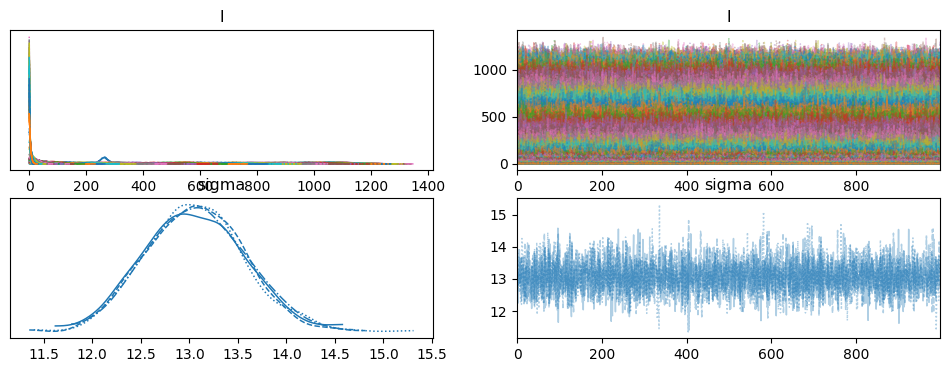

In [74]:
az.plot_trace(samples)
print('Mean R_hat is', df['r_hat'].values.mean())
print('Std R_hat is', df['r_hat'].values.std())

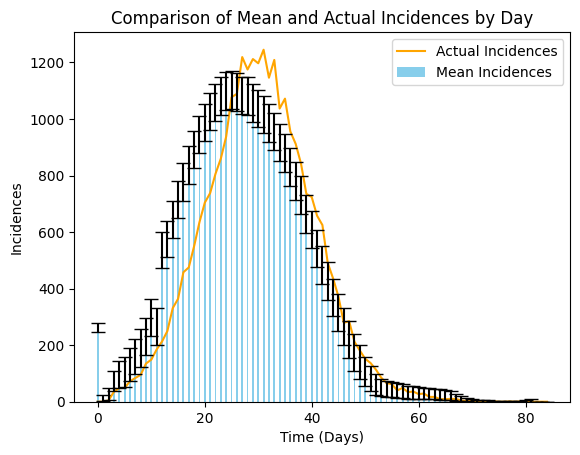

In [75]:
pre_I = np.array(list(df['mean'].values[:-1]) + kernel)
pre_std = np.array(list(df['sd'].values[:-1]) + kernel)
plt.plot(range(starting_time_point, end_time_point), incidences_true[starting_time_point:end_time_point], color='orange', label='Actual Incidences')
plt.bar(range(starting_time_point, end_time_point), pre_I, yerr=pre_std, color='skyblue', capsize=5, label='Mean Incidences', width=0.35)
# Adding details
plt.xlabel('Time (Days)')
plt.ylabel('Incidences')
plt.title('Comparison of Mean and Actual Incidences by Day')
plt.legend()
plt.show()

Problems: How to deal with the value of I[0]? There have to be some initial patients, the model will still generate an estimate of the inital "true" infection based on the model. What about just manually set that value to 0 or leave it there for users to interpret that?

Idea: May redefine the model, add a 'I[-1]' to deal with the initial patients?

## Use RStan to implement optimization methods

In [4]:
controller = epipi.OptimizerController(theta, omega)
result = controller.run()

R[write to console]: Error in library(rstan) : there is no package called ‘rstan’



RRuntimeError: Error in library(rstan) : there is no package called ‘rstan’


In [4]:
robjects.r("""library(rstan)""")

R[write to console]: Error in library(rstan) : there is no package called ‘rstan’



RRuntimeError: Error in library(rstan) : there is no package called ‘rstan’


In [3]:
mkdir -p ~/R/x86_64-pc-linux-gnu-library/4.3.3
Rscript -e "install.packages('rstan', repos = 'https://cloud.r-project.org/', dependencies = TRUE, lib='~/R/x86_64-pc-linux-gnu-library/4.3.3')"
Sys.setenv(DOWNLOAD_STATIC_LIBV8 = 1) # only necessary for Linux without the nodejs library / headers

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: Warning in install.packages("rstan", repos = c("https://mc-stan.org/r-packages/",  :
R[write to console]: 
 
R[write to console]:  'lib = "/usr/local/lib/R/site-library"' is not writable



## Recovery Model

In [67]:
omega = pd.read_csv('../EpiOS/recovery_cdf.csv')['recovery'].values
theta = pd.read_csv('../EpiOS/y_interpolated.csv')['y_interpolated'].values

In [68]:
kernel = [0]
starting_time_point = 0
end_time_point = len(theta)
controller = epipi.InferenceController(theta[starting_time_point:end_time_point], omega, kernel=kernel)
fit, samples = controller.run()
df = az.summary(samples)
df

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 28: Argument
    1700 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 22: Argument
    5000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   8% (600/8000)
Sampling:  10% (800/8000)
Sampling:  12% (1000/8000)
Sampling:  15% (1200/8000)
Sampling:  18% (1400/8000)
Sampling:  20% (1600/8000)
Sampling:  22% (1800/8000)
Sampling:  25

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
I[0],119.045,10.820,98.228,138.545,0.181,0.128,3576.0,2946.0,1.0
I[1],26.374,13.978,0.140,49.687,0.277,0.196,2212.0,1341.0,1.0
I[2],30.524,14.611,3.699,56.428,0.267,0.189,2631.0,1391.0,1.0
I[3],36.080,15.553,6.808,64.055,0.302,0.213,2479.0,1308.0,1.0
I[4],45.637,16.529,15.254,77.678,0.321,0.227,2575.0,1740.0,1.0
...,...,...,...,...,...,...,...,...,...
I[80],1.059,1.038,0.000,3.002,0.013,0.011,3556.0,2198.0,1.0
I[81],1.239,1.228,0.000,3.488,0.016,0.014,4066.0,2198.0,1.0
I[82],1.603,1.571,0.001,4.467,0.022,0.019,3408.0,1698.0,1.0
I[83],2.763,2.661,0.001,7.571,0.037,0.029,3440.0,2247.0,1.0


Mean R_hat is 1.0
Std R_hat is 0.0


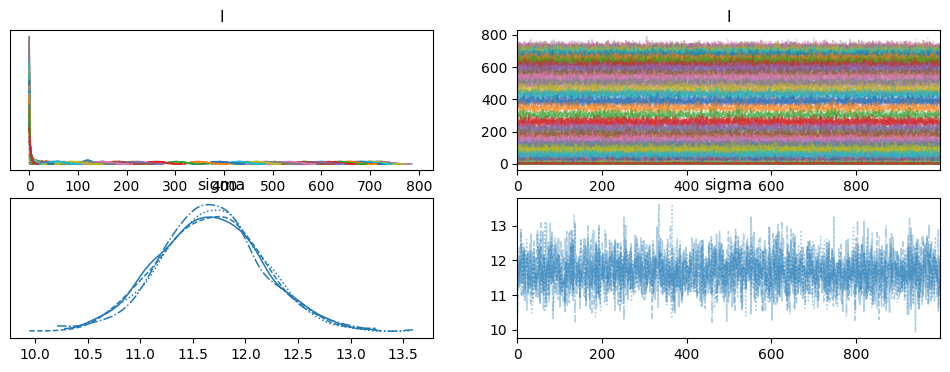

In [69]:
az.plot_trace(samples)
print('Mean R_hat is', df['r_hat'].values.mean())
print('Std R_hat is', df['r_hat'].values.std())

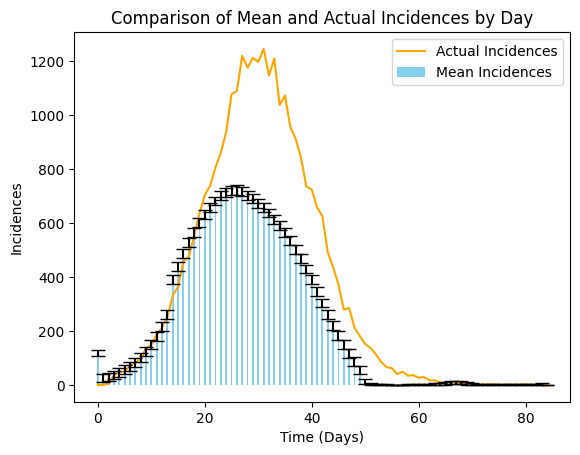

In [70]:
pre_I = np.array(list(df['mean'].values[:-1]) + kernel)
pre_std = np.array(list(df['sd'].values[:-1]) + kernel)
plt.plot(range(starting_time_point, end_time_point), incidences_true[starting_time_point:end_time_point], color='orange', label='Actual Incidences')
plt.bar(range(starting_time_point, end_time_point), pre_I, yerr=pre_std, color='skyblue', capsize=5, label='Mean Incidences', width=0.35)
# Adding details
plt.xlabel('Time (Days)')
plt.ylabel('Incidences')
plt.title('Comparison of Mean and Actual Incidences by Day')
plt.legend()
plt.show()

## Predict $R_t$

In [41]:
# Define variables needed for calculating R_t
tau = 6
R_t_start = tau+1
a = 1
b = 1/5

ws_mean = 4
ws_var = 3**2
theta_num = ws_var / ws_mean
k = ws_mean / theta_num
w_dist = scipy.stats.gamma(k, scale=theta_num)
disc_w = w_dist.pdf(range(len(theta)))
serial_interval = disc_w

In [76]:
# Plot comparison between the true and predicted R_t
# Transform our incidence data into pandas dataframes
inc_data = pd.DataFrame(
    {
        'Time': np.arange(len(theta)),
        'Incidence Number': pre_I
    }
)

inference = branchpro.BranchProPosterior(
    inc_data=inc_data,
    daily_serial_interval=serial_interval,
    alpha=a,
    beta=1/b)

inference.run_inference(tau=tau)
intervals = inference.get_intervals(central_prob=.95)

# Transform our true incidence data into pandas dataframes
inc_data_true = pd.DataFrame(
    {
        'Time': np.arange(len(theta)),
        'Incidence Number': incidences_true[:len(theta)]
    }
)

inference_true = branchpro.BranchProPosterior(
    inc_data=inc_data_true,
    daily_serial_interval=serial_interval,
    alpha=a,
    beta=1/b)

inference_true.run_inference(tau=tau)
intervals_true = inference_true.get_intervals(central_prob=.95)

fig = ReproductionNumberPlot()

fig.add_interval_true_rt(intervals_true)
fig.add_interval_rt(intervals)

fig.update_labels(time_label='Time (Day)', r_label='R_t')

fig.show_figure()

/Users/yunliqi/mambaforge/envs/limited-resources/lib/python3.11/site-packages/branchpro/apps/_reproduction_number_plot.py:27: UserWarning:

Labels do not match. They will be updated.



To do list: Write a SnakeMake file to install PyStan on Apple Silicon